> ## Build the Model

Now that we have created the spectrogram images it's time to build the computer vision model. If you are following along with the learning path then you already created a computer vision model in the second module in this path. We will be creating a computer vision model -- they may look familiar! Like always we first import the packages we need to build the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
tf.multiply(2, 3)
ipd.clear_output()

>> ###  Load Spectrogram images into a dataset for training

Here we provide the path to our image data and use `tf.keras.preprocessing.image_dataset_from_directory` to load the images into tensors.



This method is doing a lot for us. Lets take a look at a few of the params:

- labels='inferred': The labels are created based on folder directory names.
- image_size=(256, 256): resizes the image
- validation_split=0.2, subset='validation': create validation dataset

In [2]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123, 
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 1332 files belonging to 2 classes.
Using 266 files for validation.
Found 668 files belonging to 2 classes.
['no', 'yes']


>> ### Display spectrogram images

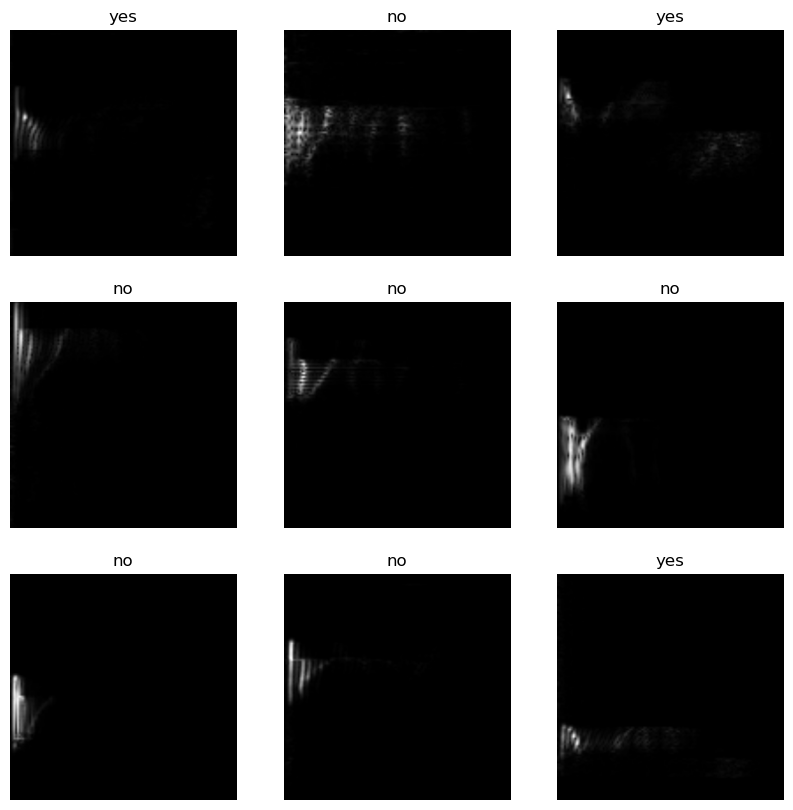

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

>> ### Create the model

In [4]:
num_classes = 2
img_height = 256
img_width = 256

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [5]:
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

>> ### Train the Model

In [6]:
# Set the epochs
epochs = 15
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, epochs=epochs)


Fitting:
Epoch 1/15


2023-01-28 10:53:23.477308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-28 10:53:25.649738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-28 10:53:25.677153: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7febdc35c870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-28 10:53:25.677170: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-01-28 10:53:25.721097: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 5s 47ms/step - loss: 0.6356 - accuracy: 0.6353
Epoch 2/15
9/9 [==============================] - 0s 21ms/step - loss: 0.5960 - accuracy: 0.6842
Epoch 3/15
9/9 [==============================] - 0s 21ms/step - loss: 0.9658 - accuracy: 0.5263
Epoch 4/15
9/9 [==============================] - 0s 21ms/step - loss: 0.6787 - accuracy: 0.5827
Epoch 5/15
9/9 [==============================] - 0s 21ms/step - loss: 0.5711 - accuracy: 0.7293
Epoch 6/15
9/9 [==============================] - 0s 21ms/step - loss: 0.6114 - accuracy: 0.7218
Epoch 7/15
9/9 [==============================] - 0s 21ms/step - loss: 0.4661 - accuracy: 0.8158
Epoch 8/15
9/9 [==============================] - 0s 21ms/step - loss: 0.5035 - accuracy: 0.7594
Epoch 9/15
9/9 [==============================] - 0s 21ms/step - loss: 0.6019 - accuracy: 0.6880
Epoch 10/15
9/9 [==============================] - 0s 21ms/step - loss: 0.5099 - accuracy: 0.7519
Epoch 11/15
9/9 [=======================

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

>> ### Test the Model

In [8]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')

1/1 [==============================] - 0s 66ms/step
Number correct: 25 out of 32
Accuracy 0.78125
